In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [9]:
# Load vmem simulation data
base_dir = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/vmem_data_neo' 

vmem_amp_file_paths = [
    os.path.join(base_dir, f'vmem_amp_data_neo_Ez_{i}.npy')
    for i in range(16)
]

vmem_amp_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in vmem_amp_file_paths
]
vmem_amp_data = {}
for data in vmem_amp_data_list:
    vmem_amp_data.update(data)

In [10]:
def analyze_feature_importance(amp_data, selected_properties, frequency):
    """Linear regression extracting regression coefficients for a feature importance analysis. (Table C.1)"""

    # Choose the frequency of interest
    at_freq = frequency

    X = []  # Feature matrix
    y = []  # Soma amplitude at the given frequency

    # Extract the soma amplitude at that frequency
    for cell_name, values in amp_data.items():
        if at_freq in values['freq']:  # Check if the frequency exists
            freq_idx = values['freq'].index(at_freq)
            soma_amp_at_freqHz = values['soma_amp'][freq_idx]

            # Collect feature values
            feature_values = [values[prop] for prop in selected_properties]
            
            # Append to lists
            X.append(feature_values)
            y.append(soma_amp_at_freqHz)

    # Convert to NumPy arrays
    X = np.array(X)
    y = np.array(y)

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit regression model
    reg = LinearRegression()
    reg.fit(X_scaled, y)

    y_pred = reg.predict(X_scaled)
    r2 = r2_score(y, y_pred)

    # Custom labels mapping
    property_name_map = {
        'total_len': 'Total z\nlength',
        'asymmetry_factor': 'Asymmetry-\nfactor',
        'soma_diam': r'$d_\mathrm{s}$',
        'avg_z_diam': r'$d_\mathrm{d}$'
    }

    # Get feature importance
    custom_labels = [property_name_map[prop] for prop in selected_properties]
    feature_importance = pd.Series(reg.coef_, index=custom_labels).sort_index()

    print(f'R^2 value = {r2}')
    print(f'Feature importance values at {frequency} Hz:\n{feature_importance}')
    
    return feature_importance

In [11]:
def plot_feature_importance(feature_importance_10, feature_importance_1000):
    """Plots feature importance values side by side (Figure 19)"""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2), sharey=False)

    max_abs_val_10 = max(abs(feature_importance_10.values.flatten()))
    y_marg_10 = 0.05 * max_abs_val_10
    ylim_10 = max_abs_val_10 + y_marg_10
    max_abs_val_1000 = max(abs(feature_importance_1000.values.flatten()))
    y_marg_1000 = 0.05 * max_abs_val_1000
    ylim_1000 = max_abs_val_1000 + y_marg_1000

    # First subplot: Feature Importance at 10 Hz
    axes[0].bar(np.arange(len(feature_importance_10)), feature_importance_10.values.flatten(), width=0.6, color='tab:brown')
    axes[0].set_ylabel('Feature Importance Value')
    axes[0].set_title(r'$f = 10$ Hz')
    axes[0].set_xticks(np.arange(len(feature_importance_10)))
    axes[0].set_xticklabels(feature_importance_10.index, rotation=0, ha='center')
    axes[0].grid(True, linestyle=':')
    axes[0].set_ylim(0-ylim_10, 0+ylim_10)

    # Add label "A"
    axes[0].text(-0.15, 1.15, 'A', transform=axes[0].transAxes, fontsize=10, fontweight='bold', va='top')

    # Second subplot: Feature Importance at 1000 Hz
    axes[1].bar(np.arange(len(feature_importance_1000)), feature_importance_1000.values.flatten(), width=0.6, color='tab:blue')
    axes[1].set_title(r'$f = 1000$ Hz')
    axes[1].set_xticks(np.arange(len(feature_importance_1000)))
    axes[1].set_xticklabels(feature_importance_1000.index, rotation=0, ha='center')
    axes[1].grid(True, linestyle=':')
    axes[1].set_ylim(0-ylim_1000, 0+ylim_1000)

    # Add label "B"
    axes[1].text(-0.15, 1.15, 'B', transform=axes[1].transAxes, fontsize=10, fontweight='bold', va='top')

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('/Users/susannedahle/Documents/Master/Code/fig_pdfs/fig3.pdf')
    plt.show()

In [12]:
selected_properties = ['asymmetry_factor', 'avg_z_diam', 'total_len', 'soma_diam']
feature_importance_10 = analyze_feature_importance(vmem_amp_data, selected_properties, frequency = 10)
feature_importance_1000 = analyze_feature_importance(vmem_amp_data, selected_properties, frequency = 1000)

R^2 value = 0.6340129456851212
Feature importance values at 10 Hz:
$d_\mathrm{d}$        0.003100
$d_\mathrm{s}$       -0.007601
Asymmetry-\nfactor    0.030596
Total z\nlength       0.015122
dtype: float64
R^2 value = 0.14447307266013498
Feature importance values at 1000 Hz:
$d_\mathrm{d}$        0.000136
$d_\mathrm{s}$       -0.000572
Asymmetry-\nfactor    0.001889
Total z\nlength      -0.000180
dtype: float64


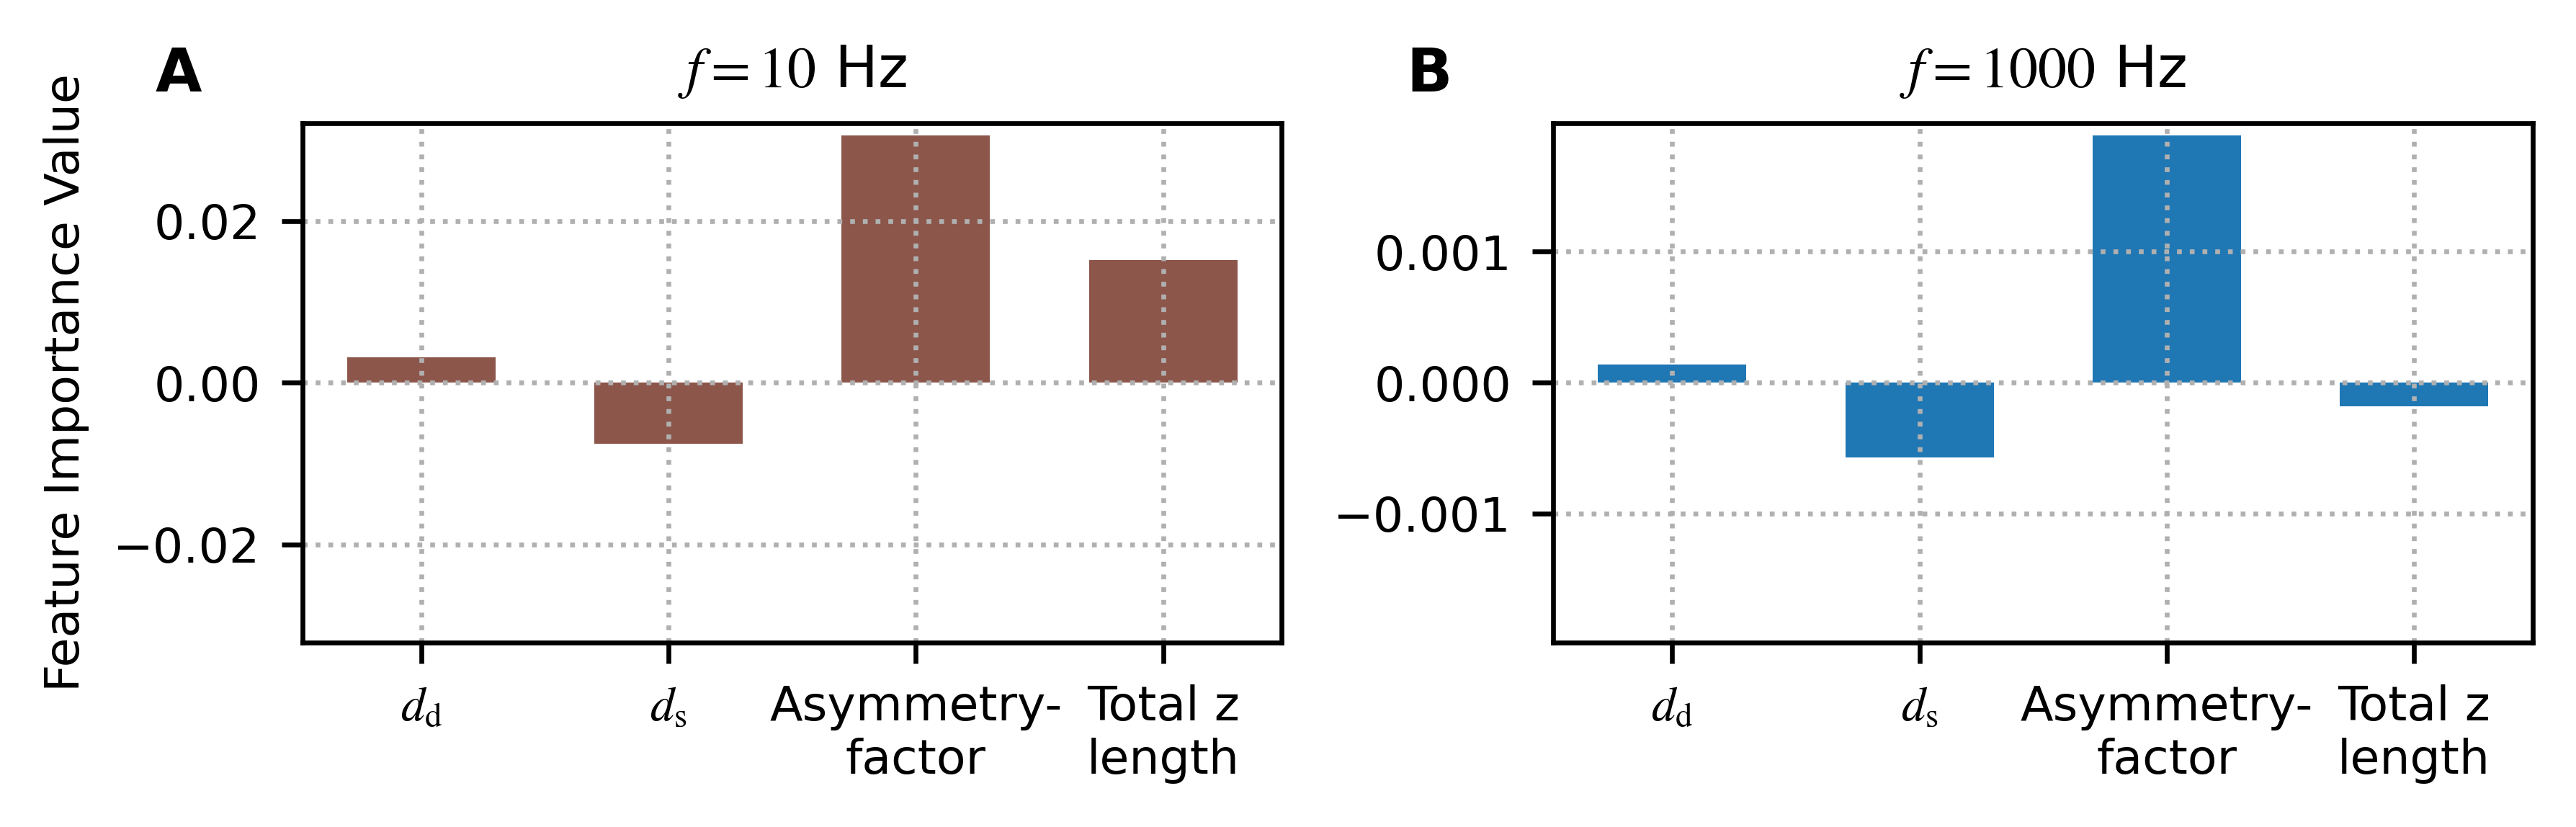

In [13]:
plot_feature_importance(feature_importance_10, feature_importance_1000)